In [1]:
# Written by David Gontier
# 09/29/2022

In this notebook, we compute the radial solution of 
$$
    D_m ψ - |Ψ|^{\frac{1}{p-1}} Ψ = λ \Psi,
$$
with $D_m$ the Dirac operator with mass $m$. This allows to compute the map $\alpha(\lambda, p)$.

In [2]:
reset

In [4]:
%pylab inline
from scipy.integrate import solve_ivp
import scipy.special as sc

Populating the interactive namespace from numpy and matplotlib


# 1d Case

In one-dimension, $\psi = (v,u)$ solves the equation
$$
    \begin{cases}
        v' = - \left( (\lambda + m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) u \\
        u' =   \left( (\lambda - m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) v
    \end{cases}
$$
The quantity $\alpha(\lambda, p)$ is the Lp norm of V, with $V = (| u |^2 + | v |^2)^{\frac{1}{p-1}}$.

In [6]:
# solves the equation with initial condition (v0, 0)
def solve_with_v0_d1(v0, args):

    # We solve the equation on the interval tt
    tt, m, λ, p = args["tt"], args["m"], args["λ"], args["p"]

    def f1(t, y):
        v, u = y
        V = (u**2 + v**2)**(1/(p-1))
        dv = - ((λ+m) + V)*u
        du = ((λ-m) + V)*v
        return array([dv, du])

    a, b = tt[0], tt[-1]
    sol = solve_ivp(f1, t_span=[a, b], y0 = [v0, 0], t_eval=tt, rtol=1e-12)
    return sol.y

# We find the best initial condition with a dichotomy
def find_psi_ode_d1(args):
    vmin, vmax = args["vmin"], args["vmax"]
    vmin0, vmax0 = vmin, vmax
    for n in range(30):
        v0 = (vmin + vmax)/2
        psi = solve_with_v0_d1(v0, args)
        v, u = psi

        # if good precision
        if norm (vmax - vmin) < 1e-7:
            print("λ = {:3}, p = {:.4f}, vmin = {:.4f}, vmax = {:.4f}, v0 = {:.4f}".format(λ, p, vmin0, vmax0, v0))
            return psi, v0
        
        # else dichotomy
        if min(v) < 1e-3: # the solution becomes negative: v0 is too high
            vmin, vmax = vmin, v0
        else: 
            vmin, vmax = v0, vmax
    print("problem, the dichotomy did not converge")
    return psi, v0

# Once we found the best solution \psi, we can compute \alpha
def alpha_ode_d1(args, psi = None):
    if psi == None:
        psi, _ = find_psi_ode_d1(args)
    v, u = psi
    
    p, tt = args["p"], args["tt"]
    eps = tt[1] - tt[0]
    V = (v**2 + u**2)**(1/(p-1))
    
    return (2*sum(V**p)*eps)**(1/p) #the Lp norm of V # The 2 factor is for the integral on R-

In [8]:
# Theoretical solutions
def get_Vth_d1(args):
    tt, m, λ, p = args["tt"], args["m"], args["λ"], args["p"]

    if λ > -m:
        A = p/(p-1)*(m**2 - λ**2)
        B = 2/(p-1)*sqrt(m**2 - λ**2)
        return A/(m*cosh(B*tt) + λ)
        
    else:
        C = 2*m/(p-1)
        return C*p/(1 + C**2 * tt**2)

def alpha_th_d1(args):
    λ, p, m = args["λ"], args["p"], args["m"]
    
    if λ > -m:
        z0 = (m-λ)/(m+λ)
        A = p**p*(m + λ)**(p-1)/(p-1)**(p-1)*z0**(p-1/2)*sc.beta(1/2, p)*sc.hyp2f1(1/2, p, p+1/2, -z0)
        return A**(1/p)

    if λ == -m:
        A = ( (p**p) * ((2*m)/(p-1))**(p-1) )*sc.beta(1/2, p-1/2)
        return A**(1/p)


In [11]:
# test

# parameters
Nb = int(1e4)
tt = linspace(0, 4, Nb)
m = 1
λ = 0.5
p = 2.1
vmin, vmax = 0.1, 5
eps = tt[1] - tt[0]

args = {  "tt": tt,    "m": m,    "λ": λ,    "p": p,    "vmin": vmin,    "vmax": vmax}

# ode values
psi, v0 = find_psi_ode_d1(args)
v, u = psi
Vode = (abs(v)**2 + abs(u)**2)**(1/(p-1))
alpha_ode = alpha_ode_d1(args)

# theoritical values
Vth = get_Vth_d1(args)
alpha_th = alpha_th_d1(args)

print("(Check V) must be 0:", norm(Vode - Vth))
print("(Check alpha) must be 0:", abs(alpha_ode - alpha_th))

λ = 0.5, p = 2.1000, vmin = 0.1000, vmax = 5.0000, v0 = 0.9797
λ = 0.5, p = 2.1000, vmin = 0.1000, vmax = 5.0000, v0 = 0.9797
(Check V) must be 0: 0.416966782868393
(Check alpha) must be 0: 0.004607003586968084


alpha =  1.1447199726158859


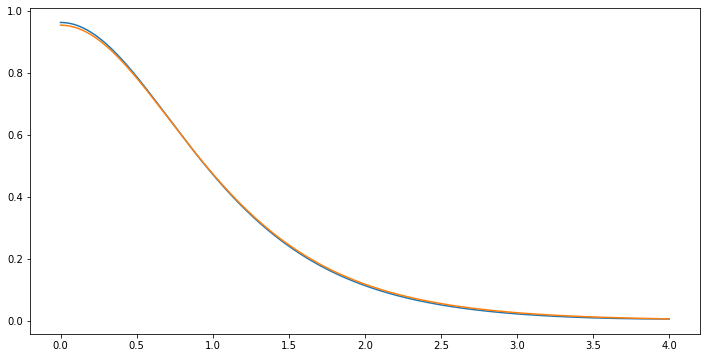

In [12]:
figsize(12, 6)

plot(tt, Vode)
plot(tt, Vth)
print("alpha = ", alpha_th)

In [13]:
### Plot \alpha_c as a function of p

pp = linspace(1+1e-6, 8, 2000)
alphac = []

for p in pp:
    args = {"m": 1,    "λ": -1,    "p": p}
    alphac.append(alpha_th_d1(args))

alpha0 = []

for p in pp:
    args = {"m": 1,    "λ": 0,    "p": p}
    alpha0.append(alpha_th_d1(args))

The maximum is attained at p = 1.318660284142071.


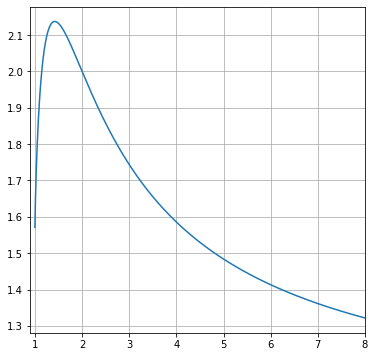

In [15]:
figsize(6, 6)
plot(pp, alpha0)
xlim(0.9,8)

grid()

#savefig('../alphac_d1.png', bbox_inches='tight')

print("The maximum is attained at p = {}.".format(pp[argmax(alphac)]))


### Plot of $\alpha ↦ \Lambda(\alpha, p)$ for several values of p


In [16]:
pp1 = [1.1, 1.2, 1.3]           # Some values below p=1.31
pp2 = [1.4, 1.5, 2, 3, 4]       # Some values above p=1.31
λλ = linspace(-1, 1 -1e-6, 100)

Np1, Np2, Nλ = len(pp1), len(pp2), len(λλ)

alpha_record1 = zeros((Np1, Nλ))
alpha_record2 = zeros((Np2, Nλ))

for ip in range(Np1):
    for iλ in range(Nλ):
        p, λ = pp1[ip], λλ[iλ]
        args = {"m": 1,    "λ": λ,    "p": p}
        alpha_record1[ip, iλ] = alpha_th_d1(args)

for ip in range(Np2):
    for iλ in range(Nλ):
        p, λ = pp2[ip], λλ[iλ]
        args = {"m": 1,    "λ": λ,    "p": p}
        alpha_record2[ip, iλ] = alpha_th_d1(args)


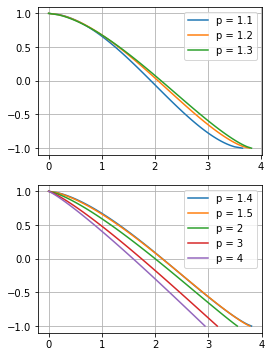

In [17]:
figsize(4, 6)
subplot(211)
for ip in range(Np1):
    p = pp1[ip]
    plot(alpha_record1[ip, :], λλ, label='p = {}'.format(p))
legend()
grid()

subplot(212)
for ip in range(Np2):
    p = pp2[ip]
    plot(alpha_record2[ip, :], λλ, label='p = {}'.format(p))
legend()
grid()

#savefig('../Lambda_d1.png', bbox_inches='tight')

# 2d case

We now focus on dimension $d = 2$. This part of the code is independent of the $d = 1$ case.

In [18]:
reset

In [21]:
%pylab inline
from scipy.integrate import solve_ivp

Populating the interactive namespace from numpy and matplotlib


The radial solution in the $n \in \Z$ space solves the equation (we write $\psi(r) = (v(r) \exp(i n \theta), i u(r) \exp i(n+1) \theta)$)
$$
    \begin{cases}
        v' = \frac{n}{r} v - \left( (\lambda + m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) u \\
        u' = -\frac{n+1}{r} u + \left( (\lambda - m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) v
    \end{cases}
$$
We focus on the two cases $n = 0$ and $n = -1$ (for the other cases, one should compute the ODE for $r^m u$ for some $m ∈ \mathbb{Z}$. This gives 
$$
    (n= 0) \quad
    \begin{cases}
        v' = - \left( (\lambda + m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) u \\
        u' = -\frac{1}{r} u + \left( (\lambda - m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) v
    \end{cases}
$$
and
$$
    (n= 1) \quad
    \begin{cases}
        v' = -\frac{1}{r} v - \left( (\lambda + m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) u \\
        u' = \left( (\lambda - m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) v
    \end{cases}
$$
In the case $n = 0$, we must have $u(0) = 0$. We notice that the function $v$ is decreasing, hence positive. This gives a dichotomy criterion to find the initial condition for $v(0)$.

In the case $n = -1$, we must have $v(0) = 0$, and, assuming that $v' < 0$, we expect to have $v < 0$ everywhere. This gives a dichotomy criterion for the initial condition $u(0) > 0$.

In [22]:
# solves the equation with initial condition (x0, 0) if n==0, and with (0, x0) if n==-1
def solve_with_x0_d2(x0, args):

    # We solve the equation on the interval tt
    tt, m, λ, p, n = args["tt"], args["m"], args["λ"], args["p"], args["n"]

    def f2(t, y):
        v, u = y
        V = (u**2 + v**2)**(1/(p-1))
        dv = n/t*v - ((λ + m) + V)*u
        du = -(n+1)/t*u + ((λ - m) + V)*v
        return array([dv, du])

    a, b = tt[0], tt[-1]
    # Case n = 0
    if n==0:
        sol = solve_ivp(f2, t_span=[a, b], y0 = [x0, 0], t_eval=tt, rtol=1e-12)
    # Case n = -1
    if n==-1:
        sol = solve_ivp(f2, t_span=[a, b], y0 = [0, x0], t_eval=tt, rtol=1e-12)
    return sol.y

# We find the best initial condition with a dichotomy
def find_psi_ode_d2(args):
    xmin, xmax = args["xmin"], args["xmax"]
    λ, p, n = args["λ"], args["p"], args["n"]
    xmin0, xmax0 = xmin, xmax

    for _ in range(100): # dichotomy
        x0 = (xmin + xmax)/2
        psi = solve_with_x0_d2(x0, args)
        v, u = psi

        # if good precision
        if norm (xmax - xmin) < 1e-7:
            print("λ = {:3}, p = {:.4f}, n = {}, xmin = {:.4f}, xmax = {:.4f}, x0 = {:.4f}".format(λ, p, n, xmin0, xmax0, x0))
            return psi, x0
        
        # else dichotomy
        if n == 0:
            if min(v) < 1e-8: # the solution becomes negative: v0 is too high
                xmin, xmax = xmin, x0
            else: 
                xmin, xmax = x0, xmax
        if n ==-1:
            if max(v) > 1e-8: # in the n=-1 case, expect v to be negative everywhere
                xmin, xmax = xmin, x0
            else: 
                xmin, xmax = x0, xmax
    print("Problem, the dichotomy did not converge")
    return psi, x0

# Once we have the solution, we can compute \alpha 
def alpha_d2(psi, args):
    v, u = psi

    p, tt = args["p"], args["tt"]
    eps = tt[1] - tt[0]
    V = (v**2 + u**2)**(1/(p-1))
    integral = 2*pi*sum(tt*V**p)*eps
    return (integral)**(1/p)



 n =  0
λ =  -1, p = 3.0000, n = 0, xmin = 0.0000, xmax = 50.0000, x0 = 6.0001
alpha =  4.393618268506922

 n =  -1
λ =  -1, p = 3.0000, n = -1, xmin = 0.0000, xmax = 50.0000, x0 = 8.0003
alpha =  5.858217563943089


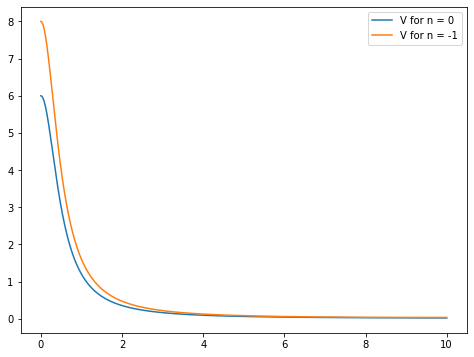

In [27]:
# test
figsize(8, 6)
 
Nb = 1000
tt = linspace(1e-6, 10, Nb)
m = 1
λ = -1
p = 3
xmin, xmax = 0, 50

# we expect that the alpha with n = 0 is lower than the one with n = -1 (better upper bound)
for n in [0, -1]:
    print("\n n = ", n)
    args = {"m": m, "λ": λ, "p": p, "tt": tt, "xmin": xmin, "xmax": xmax, "n": n}
    psi, x0 = find_psi_ode_d2(args)
    print("alpha = ", alpha_d2(psi, args) )
    
    v, u = psi
    Vode = (abs(v)**2 + abs(u)**2)**(1/(p-1))
    plot(tt, Vode, label=("V for n = {}".format(n)))

legend()


## Computation of \alpha_c for $d = 2$


In [28]:
# Case n = 0 (subscript n0)

Nb = 1000
tt = linspace(1e-6, 10, Nb)
xmin, xmax = 0, 50

pp_n0 = linspace(2+0.1, 9, 100)
alphac2_n0 = []
psi_record_n0 = []

for p in pp_n0:
    args = {"m": 1, "λ": -1, "p": p, "tt": tt, "n":0, "xmin":xmin, "xmax":xmax}
    psi, x0 = find_psi_ode_d2(args)
    psi_record_n0.append(psi)
    alphac2_n0.append(alpha_d2(psi, args))
    xmin, xmax = max(0, x0-2), x0+2


λ =  -1, p = 2.1000, n = 0, xmin = 0.0000, xmax = 50.0000, x0 = 7.8130
λ =  -1, p = 2.1697, n = 0, xmin = 5.8130, xmax = 9.8130, x0 = 6.6581
λ =  -1, p = 2.2394, n = 0, xmin = 4.6581, xmax = 8.6581, x0 = 6.1420
λ =  -1, p = 2.3091, n = 0, xmin = 4.1420, xmax = 8.1420, x0 = 5.8709
λ =  -1, p = 2.3788, n = 0, xmin = 3.8709, xmax = 7.8709, x0 = 5.7234
λ =  -1, p = 2.4485, n = 0, xmin = 3.7234, xmax = 7.7234, x0 = 5.6482
λ =  -1, p = 2.5182, n = 0, xmin = 3.6482, xmax = 7.6482, x0 = 5.6198
λ =  -1, p = 2.5879, n = 0, xmin = 3.6198, xmax = 7.6198, x0 = 5.6239
λ =  -1, p = 2.6576, n = 0, xmin = 3.6239, xmax = 7.6239, x0 = 5.6519
λ =  -1, p = 2.7273, n = 0, xmin = 3.6519, xmax = 7.6519, x0 = 5.6983
λ =  -1, p = 2.7970, n = 0, xmin = 3.6983, xmax = 7.6983, x0 = 5.7594
λ =  -1, p = 2.8667, n = 0, xmin = 3.7594, xmax = 7.7594, x0 = 5.8325
λ =  -1, p = 2.9364, n = 0, xmin = 3.8325, xmax = 7.8325, x0 = 5.9160
λ =  -1, p = 3.0061, n = 0, xmin = 3.9160, xmax = 7.9160, x0 = 6.0084
λ =  -1, p = 3.0758

maximum at p = 2.6575757575757577


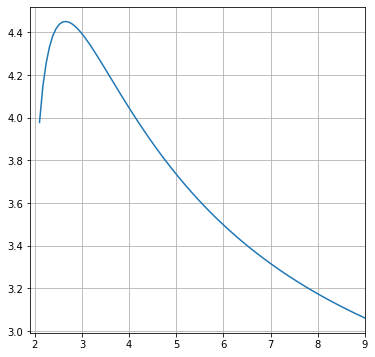

In [29]:
# Plot \alpha_c for n = 0
 
figsize(6, 6)
plot(pp_n0, alphac2_n0)
xlim(1.9,9)

grid()

print("maximum at p = {}".format(pp_n0[argmax(alphac2_n0)] ))

#savefig('../alphac_d2_n0.png', bbox_inches='tight')

In [30]:
# Case n = -1
Nb = 10000
tt = linspace(1e-6, 10, Nb)
xmin, xmax = 0, 50

pp_nm1 = linspace(3, 9, 10) # the code does not handle the case p<3  very well (the functions are peaked)
alphac2_nm1 = []
psi_record_nm1 = []

for p in pp_nm1:
    args = {"m": 1, "λ": -1, "p": p, "tt": tt, "n":-1, "xmin":xmin, "xmax":xmax}
    psi, x0 = find_psi_ode_d2(args)
    psi_record_nm1.append(psi)
    alphac2_nm1.append(alpha_d2(psi, args))
    xmin, xmax = max(0, x0-3), x0+5

λ =  -1, p = 3.0000, n = -1, xmin = 0.0000, xmax = 50.0000, x0 = 8.0003
λ =  -1, p = 3.6667, n = -1, xmin = 5.0003, xmax = 13.0003, x0 = 7.6967
λ =  -1, p = 4.3333, n = -1, xmin = 4.6967, xmax = 12.6967, x0 = 8.0923
λ =  -1, p = 5.0000, n = -1, xmin = 5.0923, xmax = 13.0923, x0 = 8.8836
λ =  -1, p = 5.6667, n = -1, xmin = 5.8836, xmax = 13.8836, x0 = 10.0105
λ =  -1, p = 6.3333, n = -1, xmin = 7.0105, xmax = 15.0105, x0 = 11.4818
λ =  -1, p = 7.0000, n = -1, xmin = 8.4818, xmax = 16.4818, x0 = 13.3398
λ =  -1, p = 7.6667, n = -1, xmin = 10.3398, xmax = 18.3398, x0 = 15.6511
λ =  -1, p = 8.3333, n = -1, xmin = 12.6511, xmax = 20.6511, x0 = 18.5050
λ =  -1, p = 9.0000, n = -1, xmin = 15.5050, xmax = 23.5050, x0 = 22.0162


maximum at p = 3.0


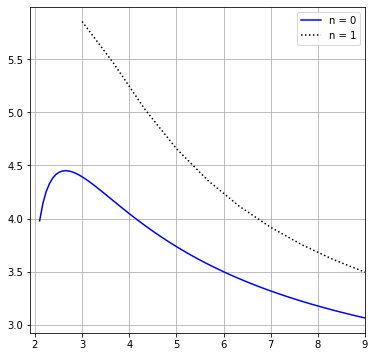

In [33]:
# Plot \alpha_c for n = -1
figsize(6, 6)
plot(pp_n0, alphac2_n0, 'b', label="n = 0")    # the previous n = 0
plot(pp_nm1, alphac2_nm1, ':k', label="n = 1") # the new
xlim(1.9,9)

grid()
legend()

print("maximum at p = {}".format(pp_nm1[argmax(alphac2_nm1)] ))
# savefig('../alphac_d2_nm1.png', bbox_inches='tight')

The curve corresponding to $n = 0$ is a better upper bound that the one for $n = -1$. In what follow, we focus on the $n = 0$ case.

### Computation of $\Lambda$ for several values of $p$, for $n = 0$

In [36]:
pp1 = [2.1, 2.4, 2.6]       # Some values of p below 2.65
pp2 = [3, 3.5, 4, 5, 6]     # Some values of p above 2.65
λλ = linspace(-1, 1 -1e-6, 100)

Nb = 1000
tt = linspace(1e-6, 10, Nb)

Np1, Np2, Nλ = len(pp1), len(pp2), len(λλ)

alpha2_record1 = zeros((Np1, Nλ))
alpha2_record2 = zeros((Np2, Nλ))

for ip in range(Np1):
    xmin, xmax = 0, 50
    for iλ in range(Nλ):
        p, λ = pp1[ip], λλ[iλ]
        args = {"m": 1, "λ": λ,    "p": p, "tt": tt, "n":0, "xmin":xmin, "xmax":xmax}

        psi, v0 = find_psi_ode_d2(args)
        alpha2_record1[ip, iλ] = alpha_d2(psi, args)
        xmin, xmax = max(0, v0-2), v0+2

for ip in range(Np2):
    xmin, xmax = 0, 50
    for iλ in range(Nλ):
        p, λ = pp2[ip], λλ[iλ]
        args = {"m": 1, "λ": λ,    "p": p, "tt": tt, "n":0, "xmin":xmin, "xmax":xmax}

        psi, v0 = find_psi_ode_d2(args)
        alpha2_record2[ip, iλ] = alpha_d2(psi, args)
        xmin, xmax = max(0, v0-2), v0+2

λ = -1.0, p = 2.1000, n = 0, xmin = 0.0000, xmax = 50.0000, x0 = 7.8130
λ = -0.9797979898989899, p = 2.1000, n = 0, xmin = 5.8130, xmax = 9.8130, x0 = 7.6271
λ = -0.9595959797979798, p = 2.1000, n = 0, xmin = 5.6271, xmax = 9.6271, x0 = 7.4562
λ = -0.9393939696969698, p = 2.1000, n = 0, xmin = 5.4562, xmax = 9.4562, x0 = 7.2943
λ = -0.9191919595959596, p = 2.1000, n = 0, xmin = 5.2943, xmax = 9.2943, x0 = 7.1391
λ = -0.8989899494949495, p = 2.1000, n = 0, xmin = 5.1391, xmax = 9.1391, x0 = 6.9894
λ = -0.8787879393939394, p = 2.1000, n = 0, xmin = 4.9894, xmax = 8.9894, x0 = 6.8445
λ = -0.8585859292929293, p = 2.1000, n = 0, xmin = 4.8445, xmax = 8.8445, x0 = 6.7039
λ = -0.8383839191919192, p = 2.1000, n = 0, xmin = 4.7039, xmax = 8.7039, x0 = 6.5673
λ = -0.818181909090909, p = 2.1000, n = 0, xmin = 4.5673, xmax = 8.5673, x0 = 6.4344
λ = -0.797979898989899, p = 2.1000, n = 0, xmin = 4.4344, xmax = 8.4344, x0 = 6.3051
λ = -0.7777778888888889, p = 2.1000, n = 0, xmin = 4.3051, xmax = 8.30

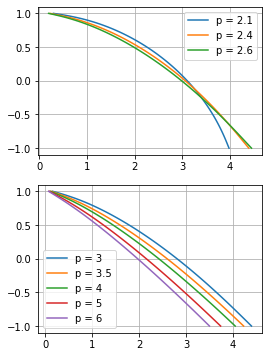

In [38]:
figsize(4, 6)
subplot(211)
for ip in range(Np1):
    p = pp1[ip]
    plot(alpha2_record1[ip, :], λλ, label='p = {}'.format(p))
legend()
grid()

subplot(212)
for ip in range(Np2):
    p = pp2[ip]
    plot(alpha2_record2[ip, :], λλ, label='p = {}'.format(p))
legend()
grid()

#savefig('../Lambda_d2.png', bbox_inches='tight')

# 3D case

The 3d case is similar to the 2d case, by replacing n by κ. This is mainly a copy-paste of the 2d section (but independent).

In [41]:
reset

In [42]:
%pylab inline
from scipy.integrate import solve_ivp

Populating the interactive namespace from numpy and matplotlib


In [45]:
# solves the equation with initial condition (v0, 0)
def solve_with_v0_d2(v0, args):

    # We solve the equation on the interval tt
    tt, m, λ, p, kappa = args["tt"], args["m"], args["λ"], args["p"], args["kappa"]

    def f3(t, y):
        v, u = y
        V = (u**2 + v**2)**(1/(p-1))
        dv = +(kappa-1)/t*u - ((λ + m) + V)*u
        du = -(kappa+1)/t*u + ((λ - m) + V)*v
        return array([dv, du])

    a, b = tt[0], tt[-1]
    sol = solve_ivp(f3, t_span=[a, b], y0 = [v0, 0], t_eval=tt, rtol=1e-12)
    return sol.y

# We find the best initial condition with a dichotomy
def find_psi_ode_d3(args):
    vmin, vmax = args["vmin"], args["vmax"]
    λ, p = args["λ"], args["p"]
    vmin0, vmax0 = vmin, vmax

    for n in range(100):
        v0 = (vmin + vmax)/2
        psi = solve_with_v0_d2(v0, args)
        v, u = psi

        # if good precision
        if norm (vmax - vmin) < 1e-7:
            print("λ = {:3}, p = {:.4f}, vmin = {:.4f}, vmax = {:.4f}, v0 = {:.4f}".format(λ, p, vmin0, vmax0, v0))
            return psi, v0
        
        # else dichotomy
        if min(v) < 1e-8: # the solution becomes negative: v0 is too high
            vmin, vmax = vmin, v0
        else: 
            vmin, vmax = v0, vmax
    print("problem")
    return psi, v0

def alpha_d3(psi, args):
    v, u = psi

    p, tt = args["p"], args["tt"]
    eps = tt[1] - tt[0]
    V = (v**2 + u**2)**(1/(p-1))
    integral = 4*pi*sum(tt**2*V**p)*eps
    return (integral)**(1/p)

λ =  -1, p = 5.0000, vmin = 0.0000, vmax = 200.0000, v0 = 25.0001
alpha =  4.746660181498212


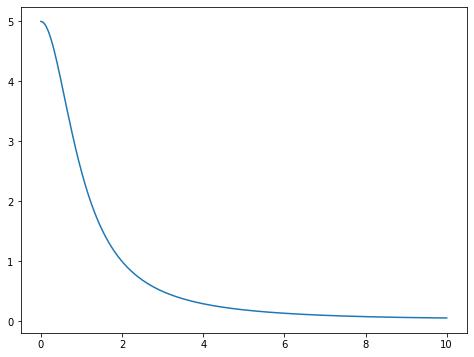

In [48]:
# test

Nb = 2000
tt = linspace(1e-6, 10, Nb)
m = 1
λ = -1
p = 5
vmin, vmax = 0, 200
kappa = 1

args = { "tt": tt, "m": m, "λ": λ, "p": p, "vmin": vmin, "vmax": vmax, "kappa": kappa }

psi, v0 = find_psi_ode_d3(args)
v, u = psi

Vode = (abs(v)**2 + abs(u)**2)**(1/(p-1))
print("alpha = ", alpha_d3(psi, args) )

figsize(8, 6)
plot(tt, Vode)

## Computation of \alpha_c for $d = 3$

In [50]:
### Plot \alpha_c
Nb = 1000
tt = linspace(1e-6, 10, Nb)
vmin, vmax = 0, 200

pp = linspace(3+0.1, 10, 200)
alphac3 = []
psi_record = []

for p in pp:
    args = {"m": 1, "λ": -1,  "p": p, "tt": tt, "kappa":1, "vmin":vmin, "vmax":vmax}
    psi, v0 = find_psi_ode_d3(args)
    psi_record.append(psi)
    alphac3.append(alpha_d3(psi, args))
    vmin, vmax = max(0, v0-20), v0+10

λ =  -1, p = 3.1000, vmin = 0.0000, vmax = 200.0000, v0 = 76.2104
λ =  -1, p = 3.1347, vmin = 56.2104, vmax = 86.2104, v0 = 60.2917
λ =  -1, p = 3.1693, vmin = 40.2917, vmax = 70.2917, v0 = 50.8671
λ =  -1, p = 3.2040, vmin = 30.8671, vmax = 60.8671, v0 = 44.6448
λ =  -1, p = 3.2387, vmin = 24.6448, vmax = 54.6448, v0 = 40.2396
λ =  -1, p = 3.2734, vmin = 20.2396, vmax = 50.2396, v0 = 36.9664
λ =  -1, p = 3.3080, vmin = 16.9664, vmax = 46.9664, v0 = 34.4470
λ =  -1, p = 3.3427, vmin = 14.4470, vmax = 44.4470, v0 = 32.4553
λ =  -1, p = 3.3774, vmin = 12.4553, vmax = 42.4553, v0 = 30.8480
λ =  -1, p = 3.4121, vmin = 10.8480, vmax = 40.8480, v0 = 29.5297
λ =  -1, p = 3.4467, vmin = 9.5297, vmax = 39.5297, v0 = 28.4341
λ =  -1, p = 3.4814, vmin = 8.4341, vmax = 38.4341, v0 = 27.5143
λ =  -1, p = 3.5161, vmin = 7.5143, vmax = 37.5143, v0 = 26.7355
λ =  -1, p = 3.5508, vmin = 6.7355, vmax = 36.7355, v0 = 26.0719
λ =  -1, p = 3.5854, vmin = 6.0719, vmax = 36.0719, v0 = 25.5037
λ =  -1, p = 3.

maximum at p = 3.862814070351759


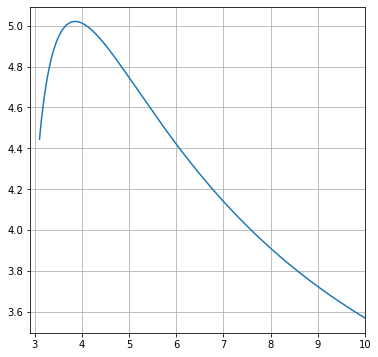

In [51]:
figsize(6, 6)
plot(pp, alphac3)
xlim(2.9,10)

grid()

print("maximum at p = {}".format(pp[argmax(alphac3)] ))
#savefig('../alphac_d3.png', bbox_inches='tight')

### Computation of $\Lambda$ for several values of $p$, for $n = 0$

In [52]:
pp1 = [3.1, 3.4, 3.8] # Some values below 3.8
pp2 = [4, 5, 6, 7, 8] # Some values above 3.8
λλ = linspace(-1, 1 -1e-6, 100)

Nb = 1000
tt = linspace(1e-6, 10, Nb)

Np1, Np2, Nλ = len(pp1), len(pp2), len(λλ)

alpha3_record1 = zeros((Np1, Nλ))
alpha3_record2 = zeros((Np2, Nλ))

for ip in range(Np1):
    vmin, vmax = 0, 500
    for iλ in range(Nλ):
        p, λ = pp1[ip], λλ[iλ]
        args = {"m": 1, "λ": λ,    "p": p, "tt": tt, "kappa":1, "vmin":vmin, "vmax":vmax}

        psi, v0 = find_psi_ode_d3(args)
        alpha3_record1[ip, iλ] = alpha_d3(psi, args)
        vmin, vmax = max(0, v0-10), v0+10

for ip in range(Np2):
    vmin, vmax = 0, 500
    for iλ in range(Nλ):
        p, λ = pp2[ip], λλ[iλ]
        args = {"m": 1, "λ": λ,    "p": p, "tt": tt, "kappa":1, "vmin":vmin, "vmax":vmax}

        psi, v0 = find_psi_ode_d3(args)
        alpha3_record2[ip, iλ] = alpha_d3(psi, args)
        vmin, vmax = max(0, v0-10), v0+10

λ = -1.0, p = 3.1000, vmin = 0.0000, vmax = 500.0000, v0 = 76.2104
λ = -0.9797979898989899, p = 3.1000, vmin = 66.2104, vmax = 86.2104, v0 = 73.7195
λ = -0.9595959797979798, p = 3.1000, vmin = 63.7195, vmax = 83.7195, v0 = 71.2707
λ = -0.9393939696969698, p = 3.1000, vmin = 61.2707, vmax = 81.2707, v0 = 68.8612
λ = -0.9191919595959596, p = 3.1000, vmin = 58.8612, vmax = 78.8612, v0 = 66.4905
λ = -0.8989899494949495, p = 3.1000, vmin = 56.4905, vmax = 76.4905, v0 = 64.1587
λ = -0.8787879393939394, p = 3.1000, vmin = 54.1587, vmax = 74.1587, v0 = 61.8666
λ = -0.8585859292929293, p = 3.1000, vmin = 51.8666, vmax = 71.8666, v0 = 59.6152
λ = -0.8383839191919192, p = 3.1000, vmin = 49.6152, vmax = 69.6152, v0 = 57.4058
λ = -0.818181909090909, p = 3.1000, vmin = 47.4058, vmax = 67.4058, v0 = 55.2396
λ = -0.797979898989899, p = 3.1000, vmin = 45.2396, vmax = 65.2396, v0 = 53.1182
λ = -0.7777778888888889, p = 3.1000, vmin = 43.1182, vmax = 63.1182, v0 = 51.0429
λ = -0.7575758787878788, p = 3.10

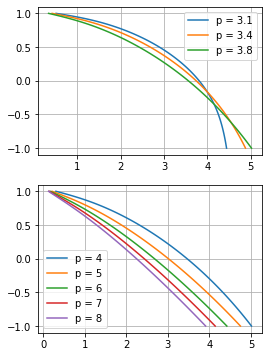

In [53]:
figsize(4, 6)
subplot(211)
for ip in range(Np1):
    p = pp1[ip]
    plot(alpha3_record1[ip, :], λλ, label='p = {}'.format(p))
legend()
grid()

subplot(212)
for ip in range(Np2):
    p = pp2[ip]
    plot(alpha3_record2[ip, :], λλ, label='p = {}'.format(p))
legend()
grid()

#savefig('../Lambda_d3.png', bbox_inches='tight')